# __Ocean regimes indicator__

Apply a Gaussian Mixtures Model to a dataset of time series

***
ds : initial dataset (lat, lon, week)

X : staked dataset (sampling, week, week_reduced)

ds_labels: unstacked final dataset (lat, lon, week)
***

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl

import seaborn as sns
sns.set_context("paper")
with_seaborn = True

import Plotter_OR
from Plotter_OR import Plotter_OR 

from PIL import Image

import importlib

## Load dataset
***

- One year of SST data in the Mediterranean Sea:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [2]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1607013925530.nc'

- One year of SST data in the North Atlantic:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [3]:
#file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1608215256580.nc'

- One year of Ocean Color data in the Mediterranean Sea:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082 product

In [4]:
#file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1610026811620.nc'

Open dataset

In [5]:
ds = xr.open_dataset(file_path)
#print(ds)
ds

<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, time: 8760)
Coordinates:
  * time                                           (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-12-31T23:30:00
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
Data variables:
    sea_surface_warm_layer_temperature_difference  (time, lat, lon) float32 ...
    sea_surface_cool_skin_temperature_difference   (time, lat, lon) float32 ...
    analysed_sst                                   (time, lat, lon) float32 ...
    mask                                           (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor L4 skin SST product
    references:                 While J., Martin M.; 2013;  Development of a ...
    institution:                UKMO
    history:                    See source and creation_date attributees
    comment:                    WARNING Some applications are unable to prope...
    license:                    These data are available free of charge under...
    id:                         UKMO-L4LRskin_GLOB-OSTIAdiu
    naming_authority:           org.ghrsst
    product_version:            1.2
    uuid:                       dd7afcc1-acf0-4a0f-9407-19d49b470b7b
    gds_version_id:             2.4
    netcdf_version_id:          4.1
    date_created:               20201203T081437Z
    start_time:                 20201202T000000Z
    time_coverage_start:        20201202T000000Z
    stop_time:                  20201202T235959Z
    time_coverage_end:          20201202T235959Z
    file_quality_level:         3
    source:                     NAVO-L2P-AVHRR19_G, OSPO-L2P-GOES15, SEVIRI_S...
    platform:                   NOAA-19, GOES15, MSG2, MTSAT2
    sensor:                     AVHRR, Imager, SEVIRI, Imager
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    metadata_link:              Not yet available
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    westernmost_longitude:      -180.0
    easternmost_longitude:      180.0
    southernmost_latitude:      -90.0
    northernmost_latitude:      90.0
    spatial_resolution:         0.25 degree
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               Met Office as part of CMEMS
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    creator_url:                http://marine.copernicus.eu/
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...
    geospatial_lat_min:         30.125
    geospatial_lat_max:         46.125
    geospatial_lon_min:         -4.875
    geospatial_lon_max:         42.875

In [6]:
var_name = 'analysed_sst'

Chlorophyll

In [7]:
#ds['time'] = ds.indexes['time'].to_datetimeindex()
#var_name = 'CHL'

__Quick plot__

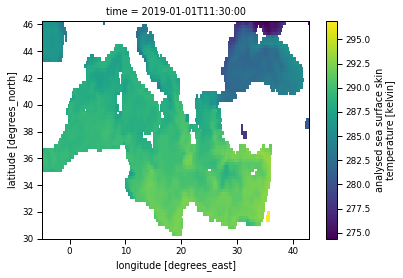

In [8]:
ds[var_name].isel(time=11).plot();

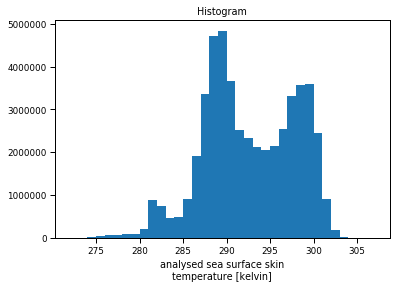

In [9]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values))
ds[var_name].plot.hist(bins=bins);

## Preprocessing
***

#### __1) Weekly mean for each pixel__

In [10]:
ds = ds.groupby("time.week").mean()
#ds = ds.groupby("time.month").mean()
#print(ds)
ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values
/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, week: 52)
Coordinates:
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
  * week                                           (week) int64 1 2 3 ... 51 52
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, lat, lon) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (week, lat, lon) float32 nan ... 0.0
    analysed_sst                                   (week, lat, lon) float32 nan ... 275.3912
    mask                                           (week, lat, lon) float32 2.0 ... 1.0

Plot histogram in time

Text(0, 0.5, 'Counts')

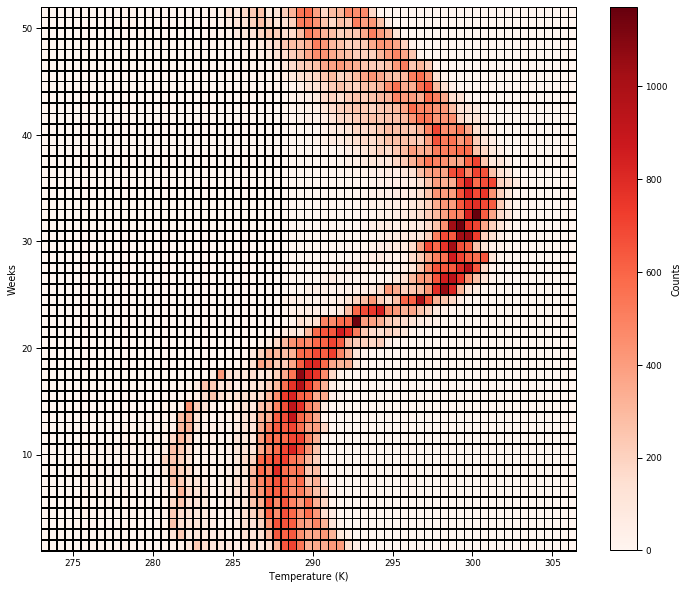

In [11]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values),0.5)
#bins = np.arange(0, 0.3, 0.002)
histo_2d = [] 
for iweek in range(52):
#for iweek in range(12):
    hist_values, bin_edges = np.histogram(ds[var_name].isel(week=iweek).values, bins=bins)
    #hist_values, bin_edges = np.histogram(ds[var_name].isel(month=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))

#plt.pcolormesh(bins, ds.month.values, histo_2d, cmap='Reds', edgecolors='black')
plt.pcolormesh(bins, ds.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
#ax.set_xlabel('Chlorophyll-a concentration (milligram m-3)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

Try chlorophyll

Text(0, 0.5, 'Counts')

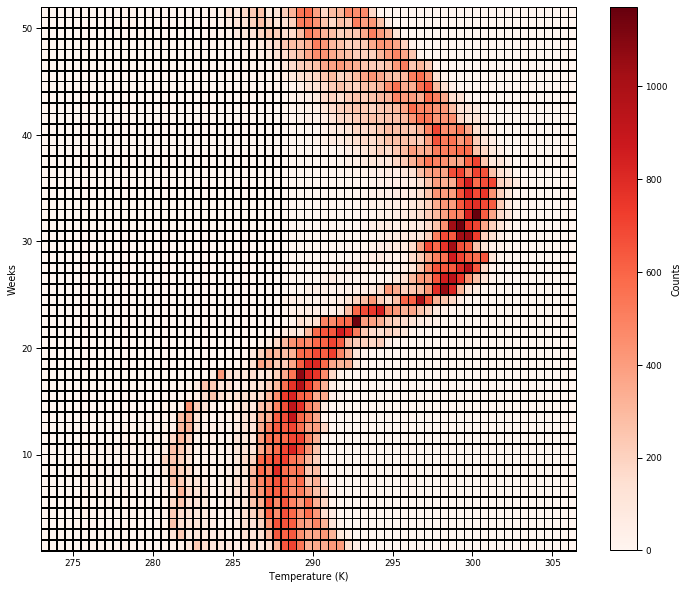

In [12]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values),0.5)
#bins = np.arange(0, 0.3, 0.002)
histo_2d = [] 
for iweek in range(52):
#for iweek in range(12):
    hist_values, bin_edges = np.histogram(ds[var_name].isel(week=iweek).values, bins=bins)
    #hist_values, bin_edges = np.histogram(ds[var_name].isel(month=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))

#plt.pcolormesh(bins, ds.month.values, histo_2d, cmap='Reds', edgecolors='black')
plt.pcolormesh(bins, ds.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
#ax.set_xlabel('Chlorophyll-a concentration (milligram m-3)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

#### __2) Reduce lat lon dimensions to sampling dimension__

In [13]:
sampling_dims = list(ds.dims)
sampling_dims.remove('week')
#sampling_dims.remove('time')
sampling_dims

['lat', 'lon']

In [14]:
X = ds.stack({'sampling': sampling_dims})
X = X.rename_dims({'week': 'feature'})
X = X.rename({'week': 'feature'})
#X = X.rename_dims({'time': 'feature'})
#X = X.rename({'time': 'feature'})
print(X)
#X

<xarray.Dataset>
Dimensions:                                        (feature: 52, sampling: 12480)
Coordinates:
  * feature                                        (feature) int64 1 2 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 30.12 ... 46.12
  - lon                                            (sampling) float64 -4.875 ... 42.88
Data variables:
    sea_surface_warm_layer_temperature_difference  (feature, sampling) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (feature, sampling) float32 nan ... 0.0
    analysed_sst                                   (feature, sampling) float32 nan ... 275.3912
    mask                                           (feature, sampling) float32 2.0 ... 1.0


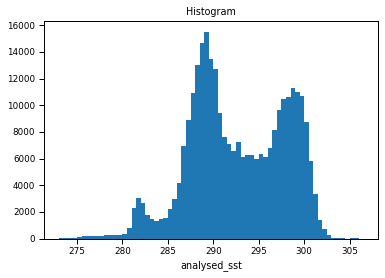

In [15]:
X[var_name].plot.hist(bins=bins);

#### __3) Delate all NaN time series using mask__

Create mask from data

In [16]:
mask_d = X[var_name].notnull()
X = X.assign(variables={"mask_d":(('feature','sampling'), mask_d)})
print(X)
#X

<xarray.Dataset>
Dimensions:                                        (feature: 52, sampling: 12480)
Coordinates:
  * feature                                        (feature) int64 1 2 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 30.12 ... 46.12
  - lon                                            (sampling) float64 -4.875 ... 42.88
Data variables:
    sea_surface_warm_layer_temperature_difference  (feature, sampling) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (feature, sampling) float32 nan ... 0.0
    analysed_sst                                   (feature, sampling) float32 nan ... 275.3912
    mask                                           (feature, sampling) float32 2.0 ... 1.0
    mask_d                                         (feature, sampling) bool False ... True


Plot created mask

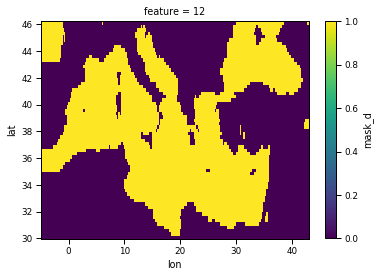

In [17]:
mask_plot = X['mask_d'].unstack('sampling')
#.sortby(['lat','lon'])
mask_plot.isel(feature=11).plot();

Plot mask in dataset (water = 1)

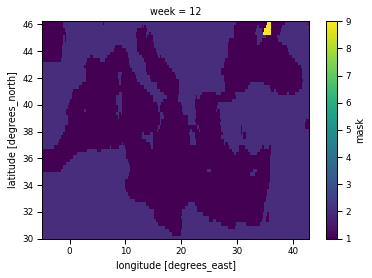

In [18]:
ds['mask'].isel(week=11).plot();

Apply mask 

In [19]:
stacked_mask = X['mask_d']
print(stacked_mask)
#stacked_mask

<xarray.DataArray 'mask_d' (feature: 52, sampling: 12480)>
array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])
Coordinates:
  * feature   (feature) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 30.12 30.12 30.12 30.12 ... 46.12 46.12 46.12
  - lon       (sampling) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88


In [20]:
X = X[var_name].where(stacked_mask == True, drop=True).to_dataset()
print(X)
#X

<xarray.Dataset>
Dimensions:       (feature: 52, sampling: 5741)
Coordinates:
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
Data variables:
    analysed_sst  (feature, sampling) float32 291.3304 291.29144 ... 275.3912


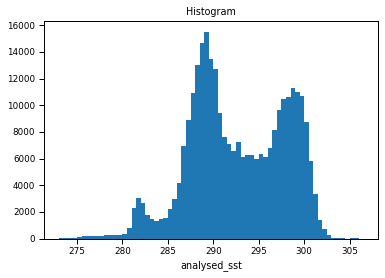

In [21]:
X[var_name].plot.hist(bins=bins);

Recover the dataset (unravel)

In [22]:
X_unstacked = X[var_name].unstack('sampling').to_dataset(name = var_name)
X_unstacked = X_unstacked.sortby(['lat','lon'])
print(np.shape(X_unstacked[var_name]))
# same lat and lon values in mask and in results
mask = stacked_mask.unstack()
X_unstacked = X_unstacked.reindex_like(mask)
print(np.shape(X_unstacked[var_name]))
print(X_unstacked) 

(52, 64, 191)
(52, 65, 192)
<xarray.Dataset>
Dimensions:       (feature: 52, lat: 65, lon: 192)
Coordinates:
  * lat           (lat) float64 30.12 30.38 30.62 30.88 ... 45.62 45.88 46.12
  * lon           (lon) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (feature, lat, lon) float32 nan nan nan ... nan nan 275.3912


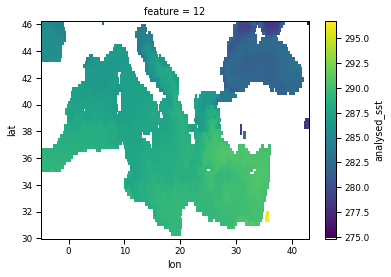

In [23]:
X_unstacked[var_name].isel(feature=11).plot();

__There is any NaN in the dataset?__

In [24]:
np.any(np.isnan(X[var_name].values))

False

#### __4) Interpolation__

Not necessary if using mask created from dataset

In [25]:
X = X[var_name].interpolate_na(dim = 'feature', method="linear", fill_value="extrapolate").to_dataset(name = var_name)
print(X)
#X

<xarray.Dataset>
Dimensions:       (feature: 52, sampling: 5741)
Coordinates:
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
Data variables:
    analysed_sst  (feature, sampling) float32 291.3304 291.29144 ... 275.3912


__There is any NaN in the dataset?__

In [26]:
np.any(np.isnan(X[var_name].values))

False

#### __5) Scaler__

__Check dimensions order__
***

In [27]:
np.shape(X[var_name])

(52, 5741)

Transpose dataset if needed (sampling x features)

In [28]:
X = X.transpose("sampling", "feature")
np.shape(X[var_name].values)

(5741, 52)

***

Apply sklearn __StandardScaler__: 
Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:

    z = (x - u) / s
    
where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 

In [29]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X[var_name])
X = X.assign(variables={var_name + "_scaled":(('sampling', 'feature'), X_scale)})
print(X)
#X

<xarray.Dataset>
Dimensions:              (feature: 52, sampling: 5741)
Coordinates:
  * feature              (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling             (sampling) MultiIndex
  - lat                  (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                  (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
Data variables:
    analysed_sst         (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled  (sampling, feature) float32 0.98910934 ... -4.903476


#### __5) PCA__

Apply __Principal component analysis__ (PCA):
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99, svd_solver = 'full')
pca

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
pca = pca.fit(X[var_name + "_scaled"])

In [ ]:
fig, ax = plt.subplots()
pb = plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
ax.set_xlabel('n_components')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of variance explained by each of the selected components')

In [ ]:
X_reduced = pca.transform(X[var_name + "_scaled"])
np.shape(X_reduced)

In [ ]:
X = X.assign(variables={var_name + "_reduced":(('sampling', 'feature_reduced'),X_reduced)})
print(X)

## Apply Model
***

__Create model__

In [ ]:
from sklearn import mixture
k = 7 # number of classes
model = mixture.GaussianMixture(n_components=k, covariance_type='full')
model

__Fit model__

In [ ]:
model.fit(X[var_name + "_reduced"])

__Predict labels__

In [ ]:
X_labels = model.predict(X[var_name + "_reduced"])
X_labels

In [ ]:
print(X_labels.min())
print(X_labels.max())

In [ ]:
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})
print(X)
#X

Calculate other __stadistics__

- Predict posterior probability of each component given the data

In [ ]:
X_proba = model.predict_proba(X[var_name + "_reduced"])
np.shape(X_proba)

In [ ]:
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)
#X

- Calculate quantiles

In [ ]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [ ]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [ ]:
X = X.assign(variables={var_name + "_Q":(('k','quantile','feature'), m_quantiles)})
X = X.assign_coords(coords={'quantile': q})
print(X)

- Calculate robustness

In [ ]:
maxpost = X["GMM_post"].max(dim="k")
K = len(X["GMM_labels"])
robust = (maxpost - 1. / K) * K / (K - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

In [ ]:
X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0
print(X)
#X

__Unstack dataset__

In [ ]:
ds_labels = X.unstack('sampling')
#ds_labels = ds_labels.sortby(['lat','lon'])
# same lat and lon values in mask and in results
mask = stacked_mask.unstack()
ds_labels = ds_labels.reindex_like(mask)
print(ds_labels)
#ds_labels

## Preprocesing plots
***

In [ ]:
#convert colormap to pallete
import matplotlib.cm
cmap=plt.cm.get_cmap('Spectral', k)
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=k)

In [ ]:
#convert to dataframe
df = ds_labels['analysed_sst_reduced'].to_dataframe(name='analysed_sst_reduced').unstack(0)
#select first and second components
df = df.take([0, 1], axis=1)
#add labels
df['labels'] = ds_labels['GMM_labels'].stack({'sampling': sampling_dims})
# do not use NaNs
df = df.dropna()

# random selection of points to make clear plots
n=1000
random_rows = np.random.choice(range(df.shape[0]), np.min((n, df.shape[0])), replace=False)
df = df.iloc[random_rows]
#format to simple dataframe
df = df.reset_index(drop=True)
df.columns = df.columns.droplevel(0)
df = df.rename_axis(None, axis=1)
df = df.rename(columns={0: "feature_reduced_0", 1: "feature_reduced_1", '': "labels"})

#defaults = {'height':2.5, 'aspect':1, 'hue':'labels', 'palette': m.plot.cmap(palette=True),
#                    'vars':m._xlabel, 'despine':False}
defaults = {'height':2.5, 'aspect':1, 'hue':'labels', 'despine':False, 'palette': cpal}
g = sns.PairGrid(df, **defaults)

g.map_diag(sns.histplot, edgecolor=None, alpha=0.75)
g = g.map_upper(plt.scatter, s=3)

g.add_legend()

## Plot results
***

In [ ]:
model

In [ ]:
ds_labels

In [ ]:
P = Plotter_OR(ds_labels, model, coords_dict={'latitude':'lat', 'longitude':'lon', 'feature': 'feature'})

#### __1) Quantiles time series__

Median and other quantiles representation

In [ ]:
P.tseries_structure(q_variable = var_name + '_Q', start_month=6, ylabel='Temperature (K)')
#P.save_BlueCloud('figures/vertical_struc_EX.png')

All median time series in the same plot 

In [ ]:
P.tseries_structure_comp(q_variable = var_name + '_Q', plot_q= 'all', ylabel='Temperature (K)', xlabel='Weeks')
#P.save_BlueCloud('figures/vertical_struc_comp_EX.png')

If temperature is normalized (__how we can interpret this figure?__)

In [ ]:
#quantile tou want to plot
plot_q = 0.5

cmap=plt.cm.get_cmap('Spectral', k)
plt.figure(figsize=(20,6))
plt.grid()
for ik in range(k):
    plt.plot(X[var_name + '_scaled'].where(X['GMM_labels']==ik, drop=True).quantile(plot_q, dim='sampling'),color=cmap(ik))

norm = mpl.colors.Normalize(vmin=0,vmax=k-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=range(k))
cbar.set_label('Classes', fontsize=12)
plt.gca().set_xlabel('Weeks')
plt.gca().set_ylabel('Normalized temperature (K)')
plt.gca().set_title("Median time series (q=0.5)", fontsize=12, fontweight='bold')
plt.gca().set_ylim([-3.5,3.5])
plt.show()

#### __2) Spatial distribution of classes__

In [ ]:
P.spatial_distribution(time_slice="2017-08")
#P.save_BlueCloud('figures/spatial_distr_EX.png')

In [ ]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='10m',facecolor='grey')
map_extent = [ds_labels['lon'].values.min()-1, ds_labels['lon'].values.max()+1, ds_labels['lat'].values.min()-1, ds_labels['lat'].values.max()+1]

fig=plt.figure(figsize=(18,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(land_feature, edgecolor='black')
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

plt.pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['GMM_labels'], vmin=0, vmax=k-1, cmap=plt.cm.get_cmap('Spectral', k))

cbar = plt.colorbar(ticks=range(k),fraction=0.016, pad=0.04)
#plt.clim([-0.5,4.5])
cbar.set_label('Classes', fontsize=12)

ax.set_xticks(np.arange(int(map_extent[0]),int(map_extent[1]),2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(int(map_extent[2]),int(map_extent[3]),2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
plt.grid(True,  linestyle='--')

ax.set_title('Spatial distribution of classes', fontsize=14, fontweight='bold')

plt.show()

#### __3) Robustness__

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import pyxpcm
###########################################################
from pyxpcm.models import pcm
z = np.arange(0,30)
pcm_features = {var_name: z}
m = pcm(K=k, features=pcm_features)
cmap = m.plot.cmap(usage='robustness')
###########################################################

extent = np.array([min(ds_labels['lon']), max(ds_labels['lon']), min(ds_labels['lat']), max(ds_labels['lat'])] + np.array([-0.1, +0.1, -0.1, +0.1]))
fig, ax = plt.subplots(figsize=(10, 20), nrows=k, ncols=1, facecolor='w', edgecolor='k', dpi=120, subplot_kw={'projection': ccrs.PlateCarree(), 'extent': extent})
#cmap=plt.cm.get_cmap('Spectral', k)
land_feature = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
#ticks
dx=4
dy=4

for ik in range(k):
    ax[ik].add_feature(land_feature, edgecolor='black')
    ax[ik].set_extent(extent, crs=ccrs.PlateCarree())
    sc = ax[ik].pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['GMM_robustness_cat'].where(ds_labels['GMM_labels'] == ik),
                            cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=5)
    ax[ik].set_title('k=%i' % ik, color=cmap(ik), fontweight='bold')    
    defaults = {'linewidth':.5, 'color':'gray', 'alpha':0.5, 'linestyle':'--'}
    gl=ax[ik].gridlines(crs=ax[ik].projection, draw_labels=True, **defaults)
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, dx))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, dy))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.xlabel_style = {'fontsize':5}
    gl.ylabels_right = False
    gl.ylabel_style = {'fontsize':5}
    
rowl0 = ds_labels['GMM_robustness_cat'].attrs['legend']
cl = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.05)
cl.set_ticks([0,1,2,3,4,5])
cl.set_ticklabels([0,0.33,0.66,0.9,0.99,1])
for (i, j) in zip(np.arange(0.5, 5, 1), rowl0):
        cl.ax.text(6, i, j, ha='left', va='center', fontsize=8)


#### __4) Classes pie chart__

In [ ]:
pcm_labels = ds_labels['GMM_labels']
cmap=plt.cm.get_cmap('Spectral', k)

for cl in range(k):
    # get labels
    pcm_labels_k = pcm_labels.where(pcm_labels == cl)
    if cl == 0:
        counts_k = pcm_labels_k.count(...)
        pie_labels = list(['K=%i' % cl])
        table_cn = list([[str(cl), str(counts_k.values)]])
    else:
        counts_k = xr.concat([counts_k, pcm_labels_k.count(...)], "k")
        pie_labels.append('K=%i' % cl)
        table_cn.append([str(cl), str(counts_k[cl].values)])

table_cn.append(['Total', str(sum([int(row[1]) for row in table_cn]))])

fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
# fig.set_cmap(kmap)

cheader = ['$\\bf{K}$', '$\\bf{Number\\ of\\ time\\ series}$']
ccolors = plt.cm.BuPu(np.full(len(cheader), 0.1))
the_table = plt.table(cellText=table_cn, cellLoc='center', loc='center',
                        colLabels=cheader, colColours=ccolors, fontsize=14, colWidths=(0.2, 0.45))

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)

explode = np.ones(k)*0.05
kmap_n = [list(cmap(i)[0:3]) for i in range(k)]
textprops = {'fontweight': "bold", 'fontsize': 12}

_, _, autotexts = ax[0].pie(counts_k, labels=pie_labels, autopct='%1.1f%%',
                            startangle=90, colors=kmap_n, explode=explode, textprops=textprops, pctdistance=0.5)

#labels in white
for autotext in autotexts:
    autotext.set_fontweight('normal')
    autotext.set_fontsize(10)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
ax[0].add_artist(centre_circle)
# fig.gca().add_artist(centre_circle)

ax[0].axis('equal')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.box(on=None)
the_table.scale(1, 1.5)
fig.suptitle('$\\bf{Classes\\ distribution}$', fontsize=14)
plt.tight_layout()
